In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import seaborn as sns

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

#nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet


import pyLDAvis.gensim_models

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('allstructuredtweets.csv', index_col=0)

In [ ]:
cols = ['id', 'date', 'username', 'name', 'place', 'tweet', 'language', 'hashtags']

for col in df.columns:
  if col not in cols:
    df.drop(col, axis=1, inplace=True)
df.head()

,id,date,username,name,place,tweet,language,hashtags
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,en,"['epr', 'freenet']"
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,en,"['zerowaste', 'plasticpollution', 'brandaudit'..."
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,en,"['zerowaste', 'plasticpollution', 'stopplastic..."
3,1427222591492722688,2021-08-16,jbvbin3t,Jean Babinet #noGreenwashing 💉💉,NaN,@buchebuche561 @ChSimonSU Ça fait longtemps qu...,fr,"['superphénix', 'epr']"
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,en,"['csr', 'epr', 'greenfinance', 'circulareconom..."


In [ ]:
df['language'] = df['language'].map(lambda x: re.sub('en', 'English', x))
df['language'] = df['language'].map(lambda x: re.sub('ar', 'Arabic', x))
df['language'] = df['language'].map(lambda x: re.sub('ca', 'Catalan', x))
df['language'] = df['language'].map(lambda x: re.sub('de', 'German', x))
df['language'] = df['language'].map(lambda x: re.sub('es', 'Spanish', x))
df['language'] = df['language'].map(lambda x: re.sub('fr', 'French', x))
df['language'] = df['language'].map(lambda x: re.sub('hi', 'Hindi', x))
df['language'] = df['language'].map(lambda x: re.sub('in', 'Indonesian', x))
df['language'] = df['language'].map(lambda x: re.sub('it', 'Italian', x))
df['language'] = df['language'].map(lambda x: re.sub('ja', 'Japanese', x))
df['language'] = df['language'].map(lambda x: re.sub('nl', 'Dutch', x))
df['language'] = df['language'].map(lambda x: re.sub('pl', 'Polish', x))
df['language'] = df['language'].map(lambda x: re.sub('pt', 'Portuguese', x))
df['language'] = df['language'].map(lambda x: re.sub('ro', 'Romanian', x))
df['language'] = df['language'].map(lambda x: re.sub('th', 'Thai', x))
df['language'] = df['language'].map(lambda x: re.sub('tl', 'Tagalog', x))
df['language'] = df['language'].map(lambda x: re.sub('tr', 'Turkish', x))

C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/728555327.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


<AxesSubplot:xlabel='language', ylabel='id'>

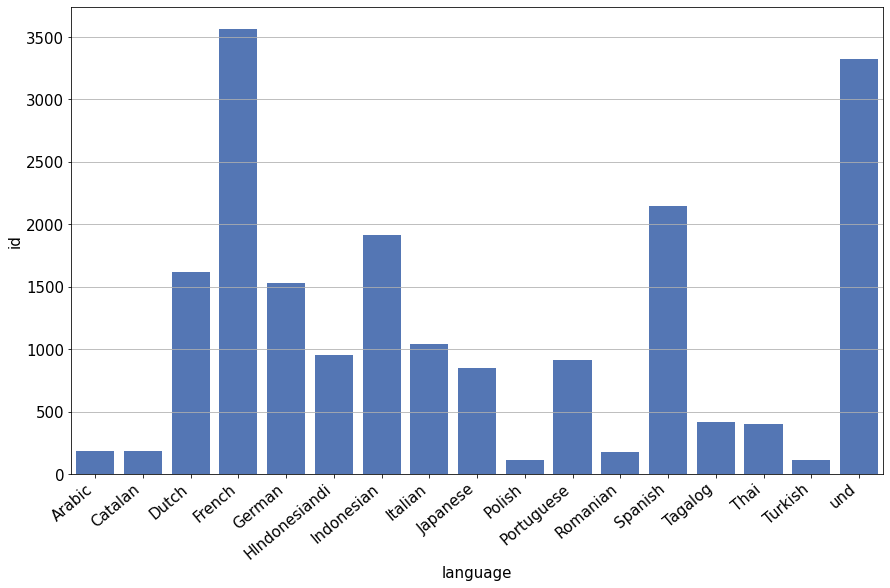

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
ax.set_ylabel("Frequency", size = 15)
ax.set_xlabel("Language", size = 15)
ax.grid(axis='y')

x = pd.DataFrame(df[df['language'] != 'English'].groupby('language')['id'].count())
x = x.reset_index()
x = x[x['id']>=100]
sns.barplot(data=x, x=x.language, y=x.id, color= '#4472c4')

In [ ]:
df = df[df['language'] == 'English']
df.head()

,id,date,username,name,place,tweet,language,hashtags
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,English,"['epr', 'freenet']"
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,English,"['zerowaste', 'plasticpollution', 'brandaudit'..."
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,English,"['zerowaste', 'plasticpollution', 'stopplastic..."
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,English,"['csr', 'epr', 'greenfinance', 'circulareconom..."
5,1427208574766358533,2021-08-16,allscriptsuk,Allscripts UK,NaN,@WWLNHS have been able to set their sights on ...,English,['epr']


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,id,date,username,name,place,tweet,language,hashtags,year,month
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,English,"['epr', 'freenet']",2021,8
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,English,"['zerowaste', 'plasticpollution', 'brandaudit'...",2021,8
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,English,"['zerowaste', 'plasticpollution', 'stopplastic...",2021,8
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,English,"['csr', 'epr', 'greenfinance', 'circulareconom...",2021,8
5,1427208574766358533,2021-08-16,allscriptsuk,Allscripts UK,NaN,@WWLNHS have been able to set their sights on ...,English,['epr'],2021,8


<AxesSubplot:xlabel='Year', ylabel='Number of tweets'>

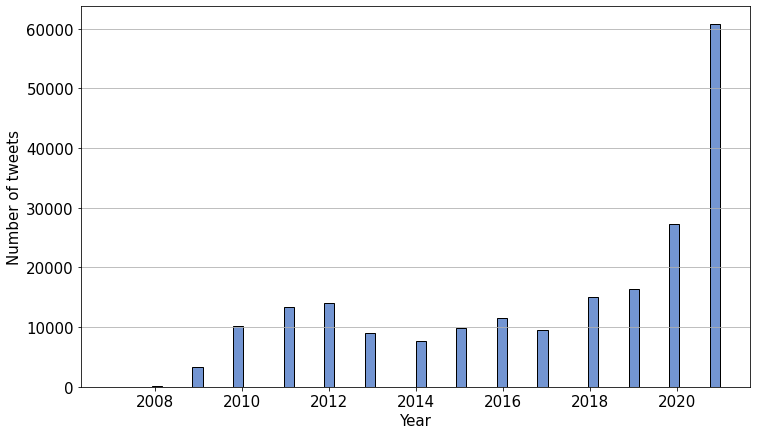

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel("Number of tweets", size = 15)
ax.set_xlabel("Year", size = 15)
ax.grid(axis='y')
sns.histplot(data=df['year'], color="#4472c4")

In [ ]:
df["hashtags"] = df["hashtags"].apply(eval)

In [ ]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

hashtag_count = to_1D(df['hashtags']).value_counts()

In [ ]:
hashtag_count = hashtag_count[hashtag_count >= 2000]

In [ ]:
hashtag_count

weee                              16413
recycling                         13491
hazardouswaste                     9633
ewaste                             8526
epr                                7266
circulareconomy                    5966
recycle                            5898
electronicwaste                    3609
waste                              3499
sustainability                     3214
environment                        3066
extendedproducerresponsibility     2551
reuse                              2546
dtype: int64

In [ ]:
ax.bar(hashtag_count.index,
        hashtag_count.values)
ax.set_ylabel("Frequency", size = 50)
ax.set_xlabel("Hashtags", size = 50)
ax.set_title("hashtags used in twitter", size = 14)
fig.autofmt_xdate()

In [ ]:
df_freq = pd.read_csv('dig_freq.csv')
df_freq

,Keywords,Frequency
0,ewaste / e-waste,115438
1,recycling,91265
2,phone / cell phone,47793
3,extended producer responsibility / EPR,24492
4,disposal,11746
5,Program,11285
6,cost,11059
7,knowledge / education,8552
8,WEEE,7982
9,electronics,7619


<AxesSubplot:title={'center':'Most popular keywords\n\n'}, xlabel='Frequency', ylabel='Keywords'>

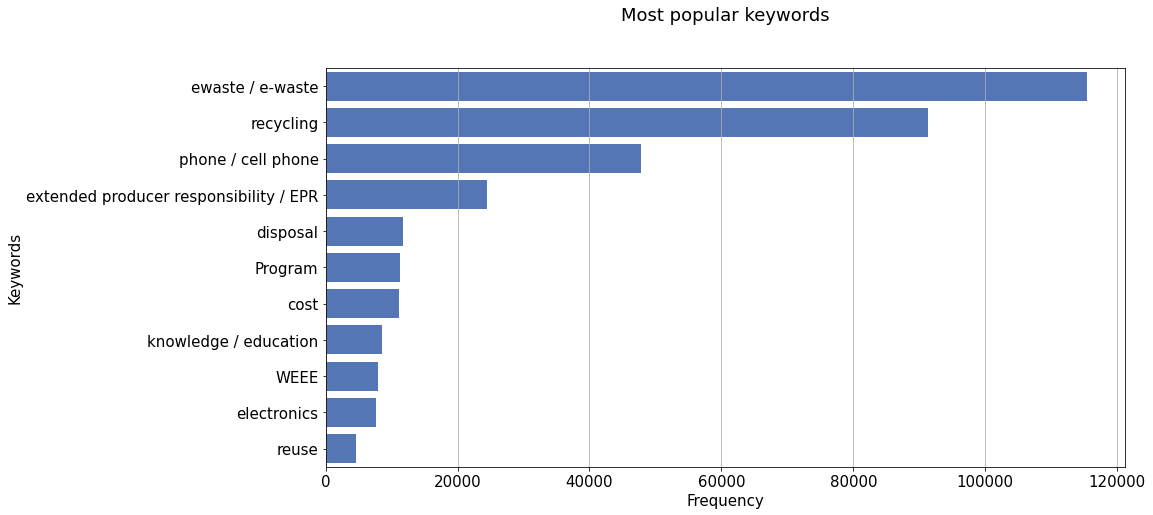

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_title('Most popular keywords\n\n', size = 18)

plt.tight_layout()
ax.set_ylabel("Keywords\n\n", size = 15)
ax.set_xlabel("\n\nFrequency", size = 15)
ax.grid(axis='x')

sns.barplot(data=df_freq, y='Keywords', x='Frequency', color='#4472c4')

In [ ]:
group_hash = df.groupby('year')['hashtags'].apply(lambda x: to_1D(x).value_counts())

C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/3712675676.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([x for _list in series for x in _list])


In [ ]:
hashPerYear = pd.DataFrame(group_hash)
hashPerYear.reset_index(level=0, inplace=True)
hashPerYear.reset_index(level=0, inplace=True)
hashPerYear = hashPerYear.rename({'index': 'hashtag', 'hashtags': 'count'}, axis=1)
hashPerYear

,hashtag,year,count
0,china20,2008,1
1,news,2008,1
2,recycling,2009,41
3,green,2009,38
4,ewaste,2009,15
...,...,...,...
53123,omemeelionsclub,2021,1
53124,mexico,2021,1
53125,vimalpanmasala,2021,1
53126,paperchoice,2021,1


<AxesSubplot:title={'center':'Most popular hashtags\n\n'}, xlabel='Year', ylabel='Number of tweets\n\n'>

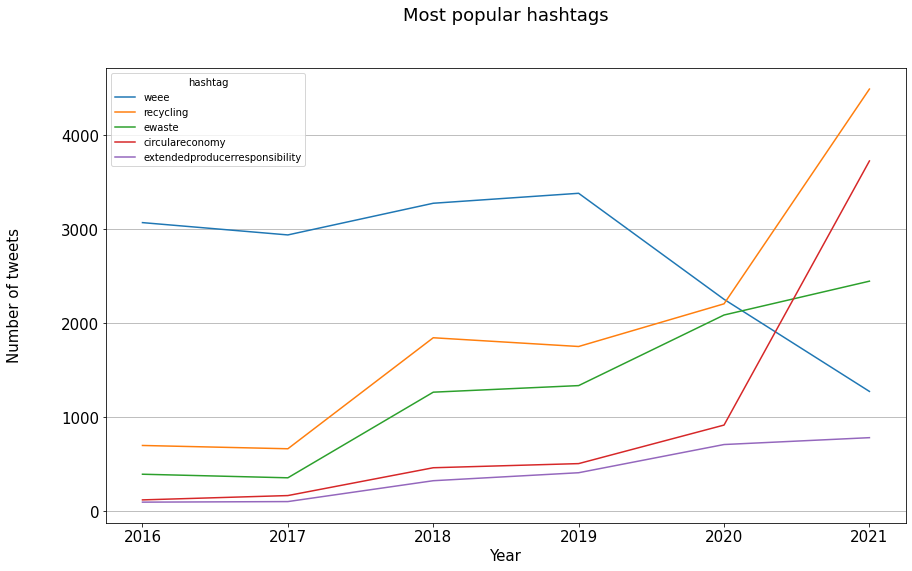

In [ ]:
hash_plot = hashPerYear.loc[ (hashPerYear['hashtag'] == 'ewaste') | (hashPerYear['hashtag'] == 'recycling') | 
                              (hashPerYear['hashtag'] == 'extendedproducerresponsibility') | (hashPerYear['hashtag'] == 'recycling')
                                | (hashPerYear['hashtag'] == 'weee') | (hashPerYear['hashtag'] == 'circulareconomy')]

fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
ax.set_ylabel("Number of tweets\n\n", size = 15)
ax.set_xlabel("Year", size = 15)
ax.set_title('Most popular hashtags\n\n', size = 18)
ax.grid(axis='y')
# ax.set_theme(style="dark")

# sns.set(rc={'figure.figsize':(12,7)})
# Plot the responses for different events and regions
sns.lineplot(x="year", y="count",
             hue="hashtag",
             #linestyle='dashed',
             data=hash_plot[hash_plot['year'] >= 2016],
             )


In [ ]:
analyzer = SentimentIntensityAnalyzer()

# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [ ]:

%%time

df['sentiment_neg'] = df['tweet'].apply(negative_score)
df['sentiment_neu'] = df['tweet'].apply(neutral_score)
df['sentiment_pos'] = df['tweet'].apply(positive_score)
df['sentiment_compound'] = df['tweet'].apply(compound_score)

Wall time: 3min 22s


Text(0.5, 0.98, 'Sentiment Analysis of tweets\n\n')

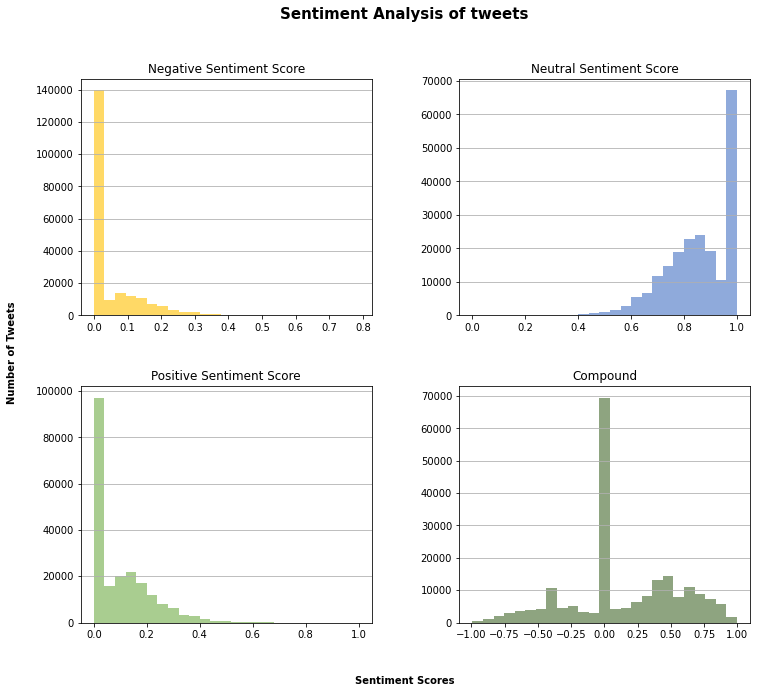

In [ ]:
# all scores in 4 histograms
fig, axes = plt.subplots(2,2, figsize=(12,10))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='#ffc000', alpha=0.6)

axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='#4472c4', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')

df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='#70ad47', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')

df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='#43682b', alpha=0.6)
axes[1,1].set_title('Compound')

axes[0,0].grid(axis='x')
axes[0,1].grid(axis='x')
axes[1,0].grid(axis='x')
axes[1,1].grid(axis='x')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Tweets', fontweight='bold', va='center', rotation='vertical')


# plot title
plt.suptitle('Sentiment Analysis of tweets\n\n', fontsize=15, fontweight='bold')

In [ ]:
def score(x):
    if x >= 0.25:
        return 'positive'
    elif x < -0.25:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_compound'].apply(lambda x: score(x))

In [ ]:
df.head(4)

,id,date,username,name,place,tweet,language,hashtags,year,month,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,English,"[epr, freenet]",2021,8,0.000,0.926,0.074,0.3818,positive
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,English,"[zerowaste, plasticpollution, brandaudit, epr,...",2021,8,0.063,0.778,0.159,0.5550,positive
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,English,"[zerowaste, plasticpollution, stopplasticwaste...",2021,8,0.080,0.800,0.120,0.1260,neutral
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,English,"[csr, epr, greenfinance, circulareconomy, sust...",2021,8,0.000,0.826,0.174,0.7783,positive


In [ ]:
# Remove punctuation
df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('[\!?()#&@]', '', x))
df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('\S*@\S*\s?', '', x)) #emails
df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('\s+', ' ', x))  # remove newline chars
# Convert to lowercase
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: x.lower())
#removing urls
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: re.sub('https?:\/\/.*[\r\n]*', '', x))
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: re.sub('www.*[\r\n]*', '', x))
# Print out the first rows of tweets
df['preprocessed_tweet'].head()

<>:2: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \/
<>:2: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \/
C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/1030708571.py:2: DeprecationWarning: invalid escape sequence \!
  df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('[\!?()#&@]', '', x))
C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/1030708571.py:3: DeprecationWarning: invalid escape sequence \S
  df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('\S*@\S*\s?', '', x)) #emails
C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/1030708571.py:4: DeprecationWarning: invalid escape sequence \s
  df['preprocessed_tweet'] = df['tweet'].map(lambda x: 

0    we want rfl staff at each of our hospitals to ...
1    @nlzerowaste has been working on this for a fe...
2    @nlzerowaste has launched its 2021 brand audit...
4    did you know that you can search for projects ...
5    @wwlnhs have been able to set their sights on ...
Name: preprocessed_tweet, dtype: object

In [ ]:
#removing stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 
                    'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 
                    'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 
                    'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

def sent_to_words(sentences):
    for sentence in sentences:
        # sentence = re.sub('\S*@\S*\s?', '', sentence)  # remove emails
        # sentence = re.sub('\s+', ' ', sentence)  # remove newline chars
        # sentence = re.sub("\'", "", sentence)  # remove single quotes
        # these have been applied in previuos steps

        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.preprocessed_tweet.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
# data_words = remove_stopwords(data_words)
# # print(data_words[:1][0][:30])
print(data_words[:1])

[['we', 'want', 'rfl', 'staff', 'at', 'each', 'of', 'our', 'hospitals', 'to', 'get', 'involved', 'in', 'epr', 'training', 'whichever', 'site', 'you', 're', 'based', 'at', 'if', 'you', 'll', 'be', 'using', 'the', 'electronic', 'patient', 'record', 'epr', 'please', 'check', 'and', 'review', 'your', 'training', 'today', 'you', 'can', 'find', 'all', 'the', 'details', 'you', 'need', 'on', 'freenet']]


In [ ]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


In [ ]:
# #A function which takes a sentence/corpus and gets its lemmatized version.
# def lemmatizeSentence(sentence):
#     token_words=word_tokenize(sentence) 
# #we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
#     lemma_sentence=[]
#     for word in token_words:
#         lemma_sentence.append(lemmatizer.lemmatize(word, pos = "v"))
#         lemma_sentence.append(" ")
#     return "".join(lemma_sentence)

# def get_wordnet_pos(word):
#   """Map POS tag to first character lemmatize() accepts"""
#   tag = nltk.pos_tag([word])[0][1][0].upper()
#   tag_dict = {"J": wordnet.ADJ,
#               "N": wordnet.NOUN,
#               "V": wordnet.VERB,
#               "R": wordnet.ADV}

#   return tag_dict.get(tag, wordnet.NOUN)

# lemmatizer = WordNetLemmatizer()

# # Lemmatize list of words and join
# df['preprocessed_tweet'] = df['preprocessed_tweet'].apply(lambda x: lemmatizeSentence(x))
# df['preprocessed_tweet'].head()

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           iterations=3000,
                                        #    random_state=100,
                                        #    update_every=1,
                                        #    chunksize=10,
                                        #    passes=10,
                                        #    alpha='symmetric',
                                        #    per_word_topics=True
                                            )

print(lda_model.print_topics())

[(0,
  '0.032*"recycling" + 0.031*"waste" + 0.030*"iphone" + 0.022*"plastic" + '
  '0.021*"recycle" + 0.014*"weee" + 0.010*"battery" + 0.010*"law" + '
  '0.010*"vote" + 0.010*"new"'),
 (1,
  '0.025*"ambitious" + 0.013*"webinar" + 0.012*"set" + 0.012*"collection" + '
  '0.011*"point" + 0.010*"register" + 0.009*"win" + 0.009*"customer" + '
  '0.009*"recycling" + 0.009*"happy"'),
 (2,
  '0.024*"recycling" + 0.020*"day" + 0.020*"great" + 0.015*"week" + '
  '0.014*"opportunity" + 0.012*"today" + 0.010*"love" + 0.010*"stand" + '
  '0.009*"idea" + 0.009*"video"'),
 (3,
  '0.022*"computer" + 0.021*"buy" + 0.010*"people" + 0.009*"stop" + '
  '0.008*"robot" + 0.008*"case" + 0.008*"price" + 0.008*"scrap" + '
  '0.007*"still" + 0.007*"never"'),
 (4,
  '0.072*"recycling" + 0.024*"waste" + 0.019*"free" + 0.018*"today" + '
  '0.018*"look" + 0.014*"service" + 0.012*"event" + 0.011*"offer" + '
  '0.011*"live" + 0.010*"late"'),
 (5,
  '0.086*"producer" + 0.083*"responsibility" + 0.052*"waste" + '
  '0.0

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str('5_tweet'))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str('5_tweet') +'.html')
LDAvis_prepared

C:\Users\Soroush\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.278743 -0.021165       1        1  25.473572
0     -0.171710 -0.081128       2        1  20.158369
6     -0.108688  0.046934       3        1  16.904764
4      0.013166  0.158425       4        1  11.949998
3      0.171058 -0.279332       5        1   9.054460
2      0.180710  0.241859       6        1   8.955404
1      0.194207 -0.065594       7        1   7.503433, topic_info=               Term          Freq         Total Category  logprob  loglift
142  responsibility  43528.000000  43528.000000  Default  30.0000  30.0000
115        producer  45352.000000  45352.000000  Default  29.0000  29.0000
44          recycle  45674.000000  45674.000000  Default  28.0000  28.0000
465        extended  22458.000000  22458.000000  Default  27.0000  27.0000
815          mobile  15481.000000  15481.000000  Default  26.0000  26.0000
..              ...           ...           ...      ...      ...      ...
74             work    851.730593   6333.239513   Topic7  -5.1953   0.5835
161           place    755.791309   2347.484345   Topic7  -5.3148   1.4565
187            year    805.916794   6162.414407   Topic7  -5.2506   0.5556
669            back    792.505891   5368.208492   Topic7  -5.2673   0.6768
43          project    699.622982   1471.161018   Topic7  -5.3920   1.8465

[449 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4471      1  0.002326     accept
4471      2  0.996553     accept
7924      2  0.001043         ad
7924      3  0.002086         ad
7924      5  0.995125         ad
...     ...       ...        ...
187       5  0.004381       year
187       6  0.011684       year
187       7  0.130793       year
1758      2  0.004220  yesterday
1758      6  0.994428  yesterday

[904 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 5, 4, 3, 2])

In [ ]:
# # Save LDA model to disk
# path_to_model = "./results/lda_5_tweet.model"
# lda_model.save(path_to_model)

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.4438,"recycling, waste, free, today, look, service, ...","[rfl, staff, hospital, involve, epr, training,..."
1,1,5.0,0.4431,"producer, responsibility, waste, extended, wee...","[nlzerowaste, working, week, launch, brand_aud..."
2,2,5.0,0.2649,"producer, responsibility, waste, extended, wee...","[launch, brand_audit, check, thread, detail, o..."
3,3,5.0,0.4954,"producer, responsibility, waste, extended, wee...","[search, project, support, different, criterio..."
4,4,4.0,0.5152,"recycling, waste, free, today, look, service, ...","[wwlnhs, able, set, sight, himss, create, heal..."
5,5,5.0,0.5095,"producer, responsibility, waste, extended, wee...","[integrate, care, system, work, together, depl..."
6,6,3.0,0.2889,"computer, buy, people, stop, robot, case, pric...","[quick, access, patient_record, improve, avail..."
7,7,1.0,0.3422,"ambitious, webinar, set, collection, point, re...","[really, great, article, forbe, future, platfo..."
8,8,5.0,0.5187,"producer, responsibility, waste, extended, wee...","[epr, packaging, law, effective, way, address,..."
9,9,0.0,0.3503,"recycling, waste, iphone, plastic, recycle, we...","[excellent, summary, regard, lie, plastic, rec..."


In [ ]:
df_dominant_topic.head(4)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.4438,"recycling, waste, free, today, look, service, ...","[rfl, staff, hospital, involve, epr, training,..."
1,1,5.0,0.4431,"producer, responsibility, waste, extended, wee...","[nlzerowaste, working, week, launch, brand_aud..."
2,2,5.0,0.2649,"producer, responsibility, waste, extended, wee...","[launch, brand_audit, check, thread, detail, o..."
3,3,5.0,0.4954,"producer, responsibility, waste, extended, wee...","[search, project, support, different, criterio..."


In [ ]:
df_dominant_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208286 entries, 0 to 208285
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Document_No         208286 non-null  int64  
 1   Dominant_Topic      208286 non-null  float64
 2   Topic_Perc_Contrib  208286 non-null  float32
 3   Keywords            208286 non-null  object 
 4   Text                208286 non-null  object 
dtypes: float32(1), float64(1), int64(1), object(2)
memory usage: 7.2+ MB


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9524,"recycling, waste, iphone, plastic, recycle, weee, battery, law, vote, new","[battery, pollute, environment, firm, datum, frequently, user, change, battery, ply, power, supp..."
1,1.0,0.8837,"ambitious, webinar, set, collection, point, register, win, customer, recycling, happy","[pride, share, eece, deliver, session, training, gurugram, topic]"
2,2.0,0.9036,"recycling, day, great, week, opportunity, today, love, stand, idea, video","[new, converge, blog, work, idea, member, great, idea]"
3,3.0,0.9051,"computer, buy, people, stop, robot, case, price, scrap, still, never","[scrap, big, picture, look, scrap, big, picture, look, editorial_staf]"
4,4.0,0.9311,"recycling, waste, free, today, look, service, event, offer, live, late","[ctvnew, article, talk, important, properly, dispose, waste, greentec, website, provide, service..."
5,5.0,0.9591,"producer, responsibility, waste, extended, weee, extend, electrical, electronic, equipment, recy...","[extended, producer, responsibility, scheme, reduce, amount, plastic, waste, shift, burden, coll..."
6,6.0,0.9464,"recycle, recycling, old, mobile, phone, electronic, equipment, waste, item, refurbish","[profofmusic, last, month, old, tech, stuff, recycle, today, send, lbs, paper, last, year, shred..."


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,20), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 45), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,45,100))
plt.title('Distribution of Document Word Counts \n', fontdict=dict(size=20))
plt.show()

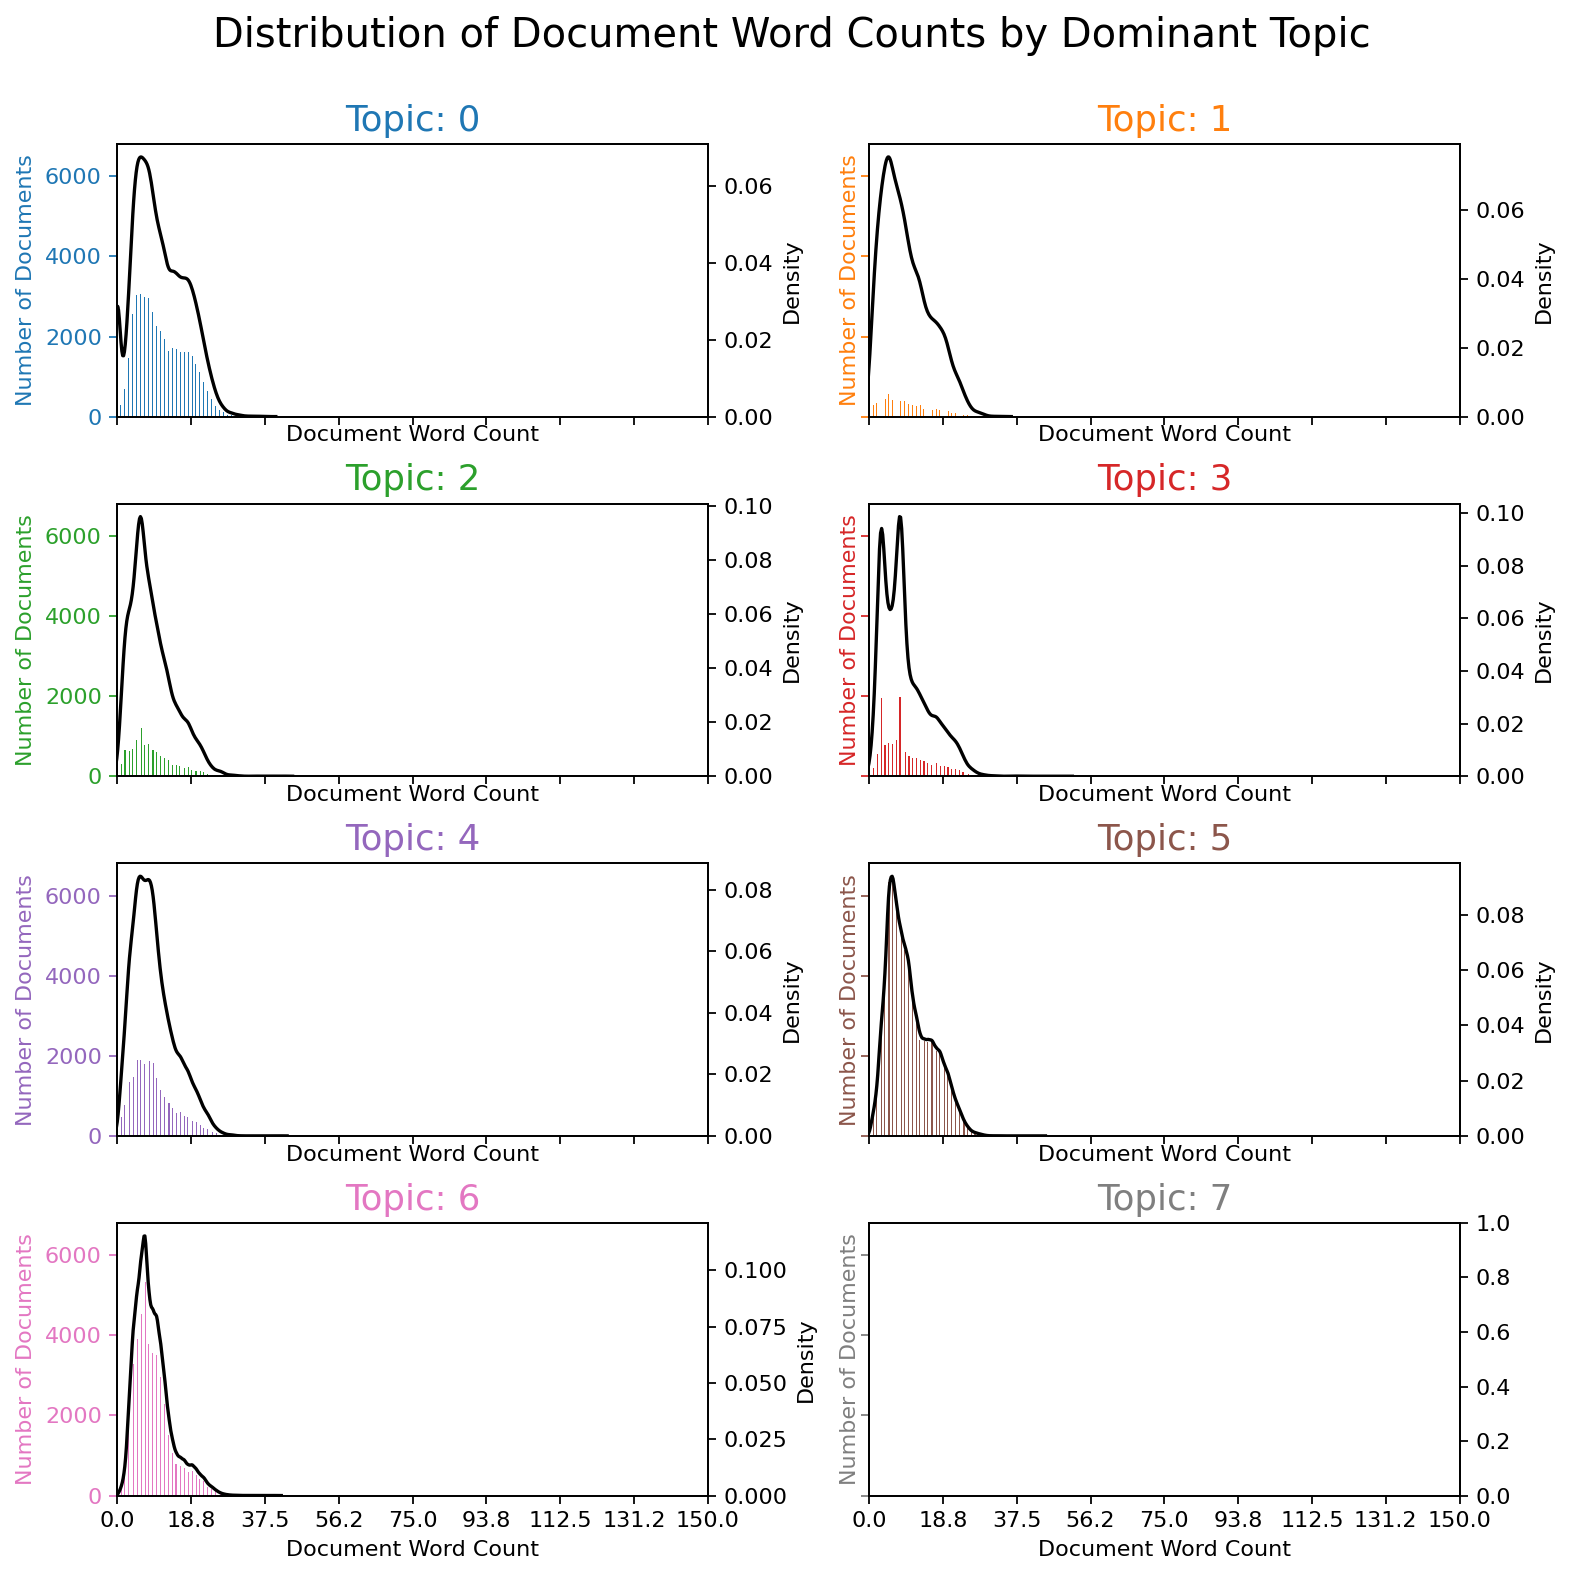

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(10,10), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 150, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 150), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,150,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=18)
plt.show()

C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/473764424.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_importance.loc[df_importance.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


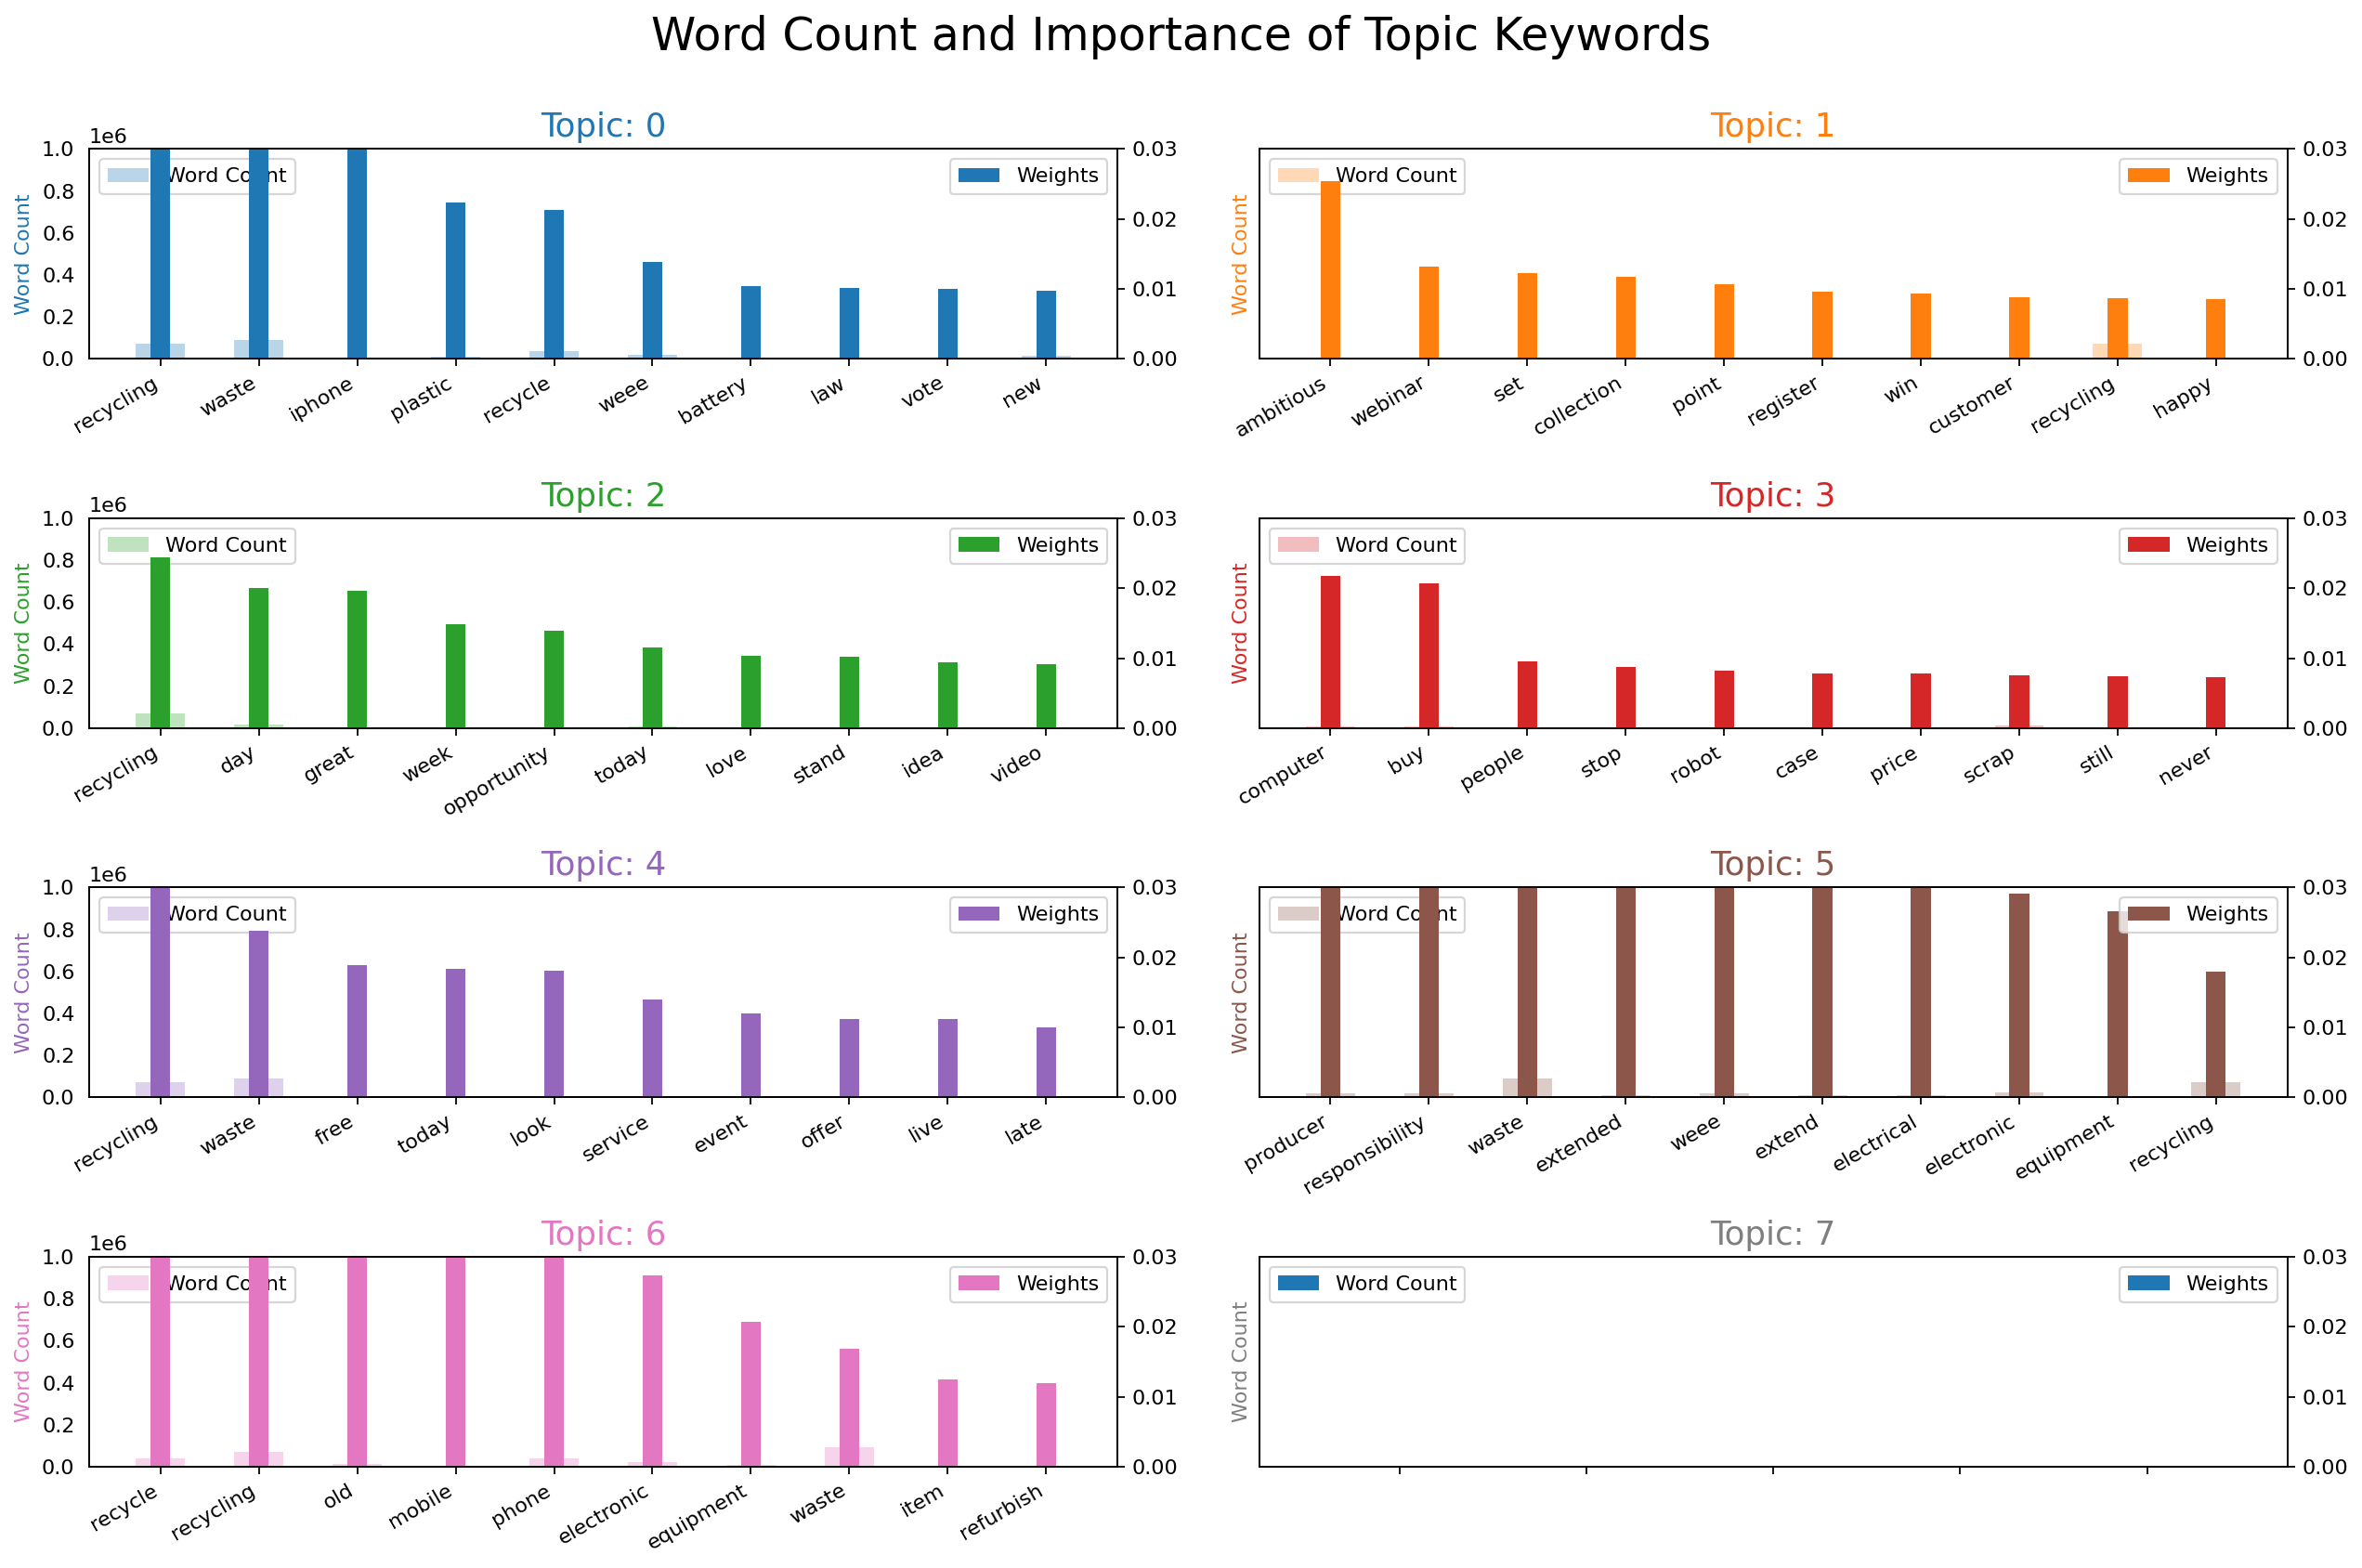

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_importance = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_importance.loc[df_importance.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_importance.loc[df_importance.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1000000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_importance.loc[df_importance.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [ ]:
# lda_model.save("E:\\Media, Docs & Programs\\Uni\\Master's\\Article\\Analysis\\Phasell\\Code\\lda.model")

In [ ]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9524,"recycling, waste, iphone, plastic, recycle, weee, battery, law, vote, new","[battery, pollute, environment, firm, datum, frequently, user, change, battery, ply, power, supp..."
1,1.0,0.8837,"ambitious, webinar, set, collection, point, register, win, customer, recycling, happy","[pride, share, eece, deliver, session, training, gurugram, topic]"
2,2.0,0.9036,"recycling, day, great, week, opportunity, today, love, stand, idea, video","[new, converge, blog, work, idea, member, great, idea]"
3,3.0,0.9051,"computer, buy, people, stop, robot, case, price, scrap, still, never","[scrap, big, picture, look, scrap, big, picture, look, editorial_staf]"
4,4.0,0.9311,"recycling, waste, free, today, look, service, event, offer, live, late","[ctvnew, article, talk, important, properly, dispose, waste, greentec, website, provide, service..."
5,5.0,0.9591,"producer, responsibility, waste, extended, weee, extend, electrical, electronic, equipment, recy...","[extended, producer, responsibility, scheme, reduce, amount, plastic, waste, shift, burden, coll..."
6,6.0,0.9464,"recycle, recycling, old, mobile, phone, electronic, equipment, waste, item, refurbish","[profofmusic, last, month, old, tech, stuff, recycle, today, send, lbs, paper, last, year, shred..."


In [ ]:
df = df.reset_index()

In [ ]:
results = pd.concat([df, df_dominant_topic], axis=1)

In [ ]:
results = results.drop('index', 1)

C:\Users\Soroush\AppData\Local\Temp/ipykernel_8516/4218491208.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  results = results.drop('index', 1)


In [ ]:
results.head(1)

,id,date,username,name,place,tweet,language,hashtags,year,month,...,sentiment_neu,sentiment_pos,sentiment_compound,sentiment,preprocessed_tweet,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to get involved in EPR training. Whichever site you...,English,"[epr, freenet]",2021,8,...,0.926,0.074,0.3818,positive,we want rfl staff at each of our hospitals to get involved in epr training. whichever site you'r...,0,4.0,0.4438,"recycling, waste, free, today, look, service, event, offer, live, late","[rfl, staff, hospital, involve, epr, training, site, base, electronic, patient_record, epr, chec..."


In [ ]:
# results.to_csv('tweet_and_topics_together.csv')

In [ ]:
topic_counts = results.groupby('Dominant_Topic')['tweet'].count()

<AxesSubplot:title={'center':'Frequency of topics between tweets\n\n'}, xlabel='Dominant_Topic', ylabel='tweet'>

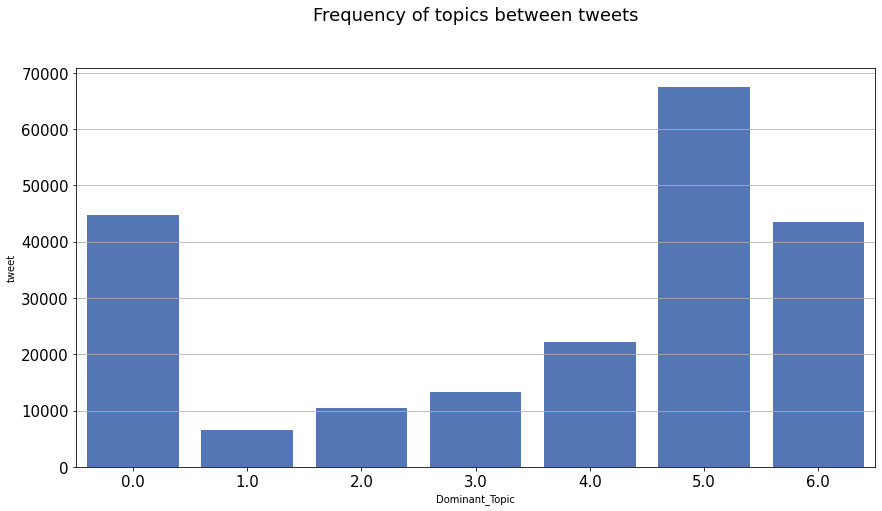

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_title('Frequency of topics between tweets\n\n', size = 18)

plt.tight_layout()
ax.grid(axis='y')

# sns.barplot(data=df_freq, y='Keywords', x='Frequency', color='#4472c4')
sns.barplot(data=pd.DataFrame(topic_counts).reset_index(), x='Dominant_Topic', y='tweet', color='#4472c4')

In [ ]:
topic_sentiment_counts = results.groupby(['Dominant_Topic', 'sentiment'])['tweet'].count()

<AxesSubplot:title={'center':'Frequency of topics between tweets\n\n'}, xlabel='Dominant_Topic', ylabel='tweet'>

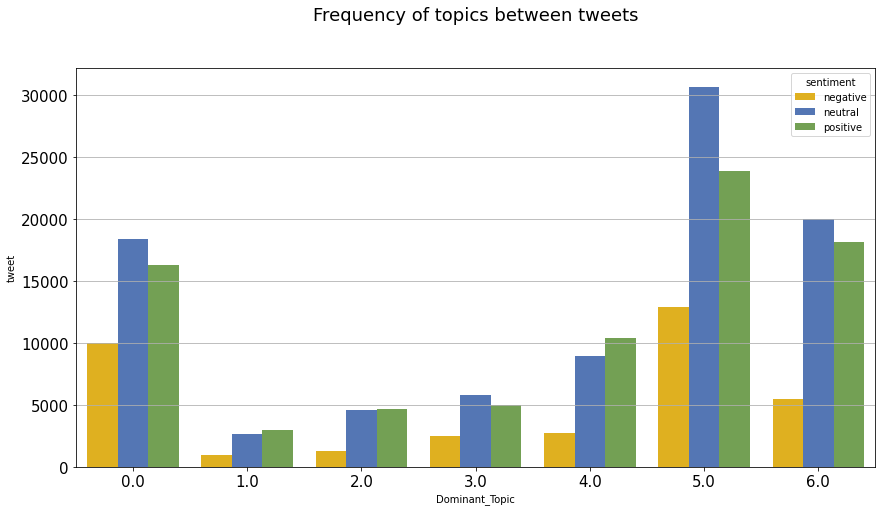

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
ax.tick_params(axis='both', labelsize=15)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_title('Frequency of topics between tweets\n\n', size = 18)

plt.tight_layout()
ax.grid(axis='y')

# sns.barplot(data=df_freq, y='Keywords', x='Frequency', color='#4472c4')
sns.barplot(data=pd.DataFrame(topic_sentiment_counts).reset_index(), 
                        x='Dominant_Topic', y='tweet', color='blue', hue='sentiment', palette=["#ffc000", "#4472c4", "#70ad47"])